In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


In [2]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
matplotlib.rcParams.update({'font.size': 12})


In [3]:
pairs = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess.pickle")
pairs = pairs.reset_index(drop=True)

In [4]:
within_dim_accs = []
across_dim_accs = []
overall_accs = []
for (feat1, feat2) in pairs.pair.values:
    within_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}_within_cond_accs.npy"))
    across_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}_across_cond_accs.npy"))
    overall_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}_overall_accs.npy"))
    within_dim_accs.append(within_dim_acc)
    across_dim_accs.append(across_dim_acc)
    overall_accs.append(overall_acc)
within_dim_accs = np.hstack(within_dim_accs)
across_dim_accs = np.hstack(across_dim_accs)
overall_accs = np.hstack(overall_accs)

Text(0.5, 0, 'Time Relative to Stimulus Onset (s)')

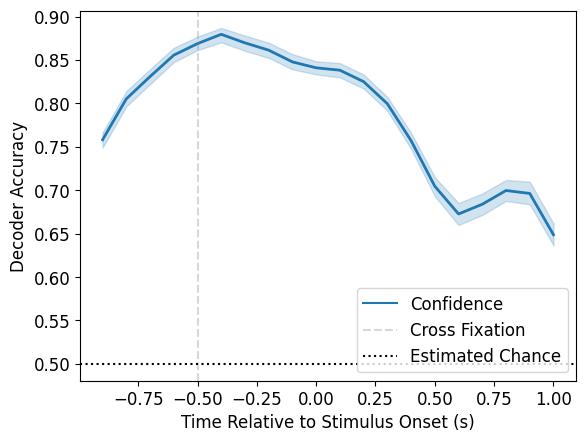

In [5]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [overall_accs], 
    ["Confidence"], 
    PRE_INTERVAL, INTERVAL_SIZE, ax)
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cross Fixation")

# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Stimulus Onset (s)")


Text(0.5, 0, 'Time Relative to Stimulus Onset (s)')

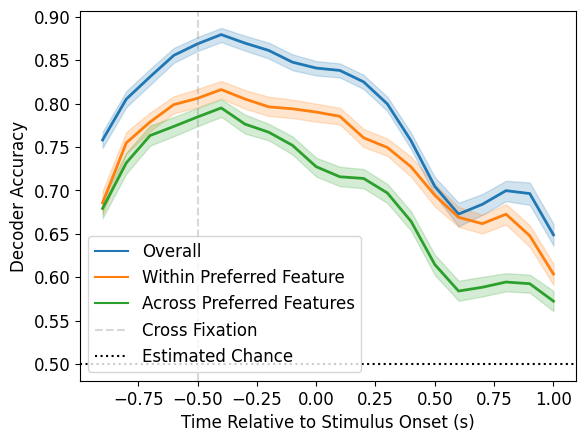

In [6]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [overall_accs, within_dim_accs, across_dim_accs, ], 
    ["Overall", "Within Preferred Feature", "Across Preferred Features"], 
    PRE_INTERVAL, INTERVAL_SIZE, ax)
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cross Fixation")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Stimulus Onset (s)")
